# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [86]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

In [87]:
df = pd.read_csv('Data/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
3181,7651,52603,NaN,18-03-2020,LA Mayor Eric Garcetti Grocery store workers h...,Positive
24876,34246,79198,NaN,06-04-2020,19 7 72 605 LPG cylinders have been delivered ...,Negative
17138,24658,69610,London base - Global & Virtual,25-03-2020,Fear is.....waiting 90 minutes for the online ...,Negative
20334,28602,73554,Maui,27-03-2020,The ÃÂgoodÃÂthing abt #coronavirus #econom...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [88]:
df['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [89]:
df['Sentiment'] = df['Sentiment'].map({'Positive': 1, 'Negative': 0, 'Extremely Positive': 1, 'Extremely Negative': 0})
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0
4,3804,48756,"ÃÂT: 36.319708,-82.363649",16-03-2020,As news of the regionÃÂs first confirmed COV...,1


Сбалансированы ли классы?

In [90]:
df['Sentiment'].value_counts().values

array([18046, 15398])

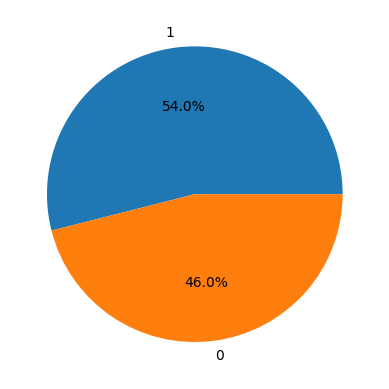

In [91]:
plt.pie(x=df['Sentiment'].value_counts().values,labels=df['Sentiment'].value_counts().index, autopct='%1.1f%%');

**Ответ:** Можно сказать, что классы не идеально сбалансированы, но явного дисбаланса нет

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [92]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [93]:
df['Location'] = df['Location'].fillna('Unknown')
df.isnull().sum()

UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [ ]:
from sklearn.model_selection import train_test_split

om_train, test = train_test_split(df, test_size=0.3, randstate=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [34]:
from collections import Counter

tokenizer = Counter(train['OriginalTweet'].str.lower().str.split().explode().to_list())
tokenizer

Counter({'the': 26815,
         'to': 23373,
         'and': 14684,
         'of': 13012,
         'a': 11737,
         'in': 11198,
         'for': 8566,
         '#coronavirus': 8223,
         'is': 7383,
         'are': 7050,
         'you': 5467,
         'on': 5452,
         'i': 5340,
         'at': 4642,
         'this': 4581,
         'with': 4063,
         'prices': 3891,
         'food': 3820,
         'we': 3787,
         'have': 3770,
         'that': 3741,
         'as': 3694,
         'be': 3570,
         'grocery': 3469,
         'supermarket': 3288,
         'people': 3175,
         'covid-19': 3173,
         'store': 3155,
         'it': 3150,
         'from': 3045,
         'all': 2808,
         'your': 2784,
         'will': 2726,
         'not': 2714,
         '#covid19': 2471,
         'our': 2460,
         'my': 2445,
         '&amp;': 2314,
         'they': 2309,
         'has': 2304,
         'consumer': 2245,
         'by': 2236,
         'or': 2234,
         '

Какой размер словаря получился?

In [35]:
len(tokenizer)

79755

Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [36]:
tokenizer.most_common(10)

[('the', 26815),
 ('to', 23373),
 ('and', 14684),
 ('of', 13012),
 ('a', 11737),
 ('in', 11198),
 ('for', 8566),
 ('#coronavirus', 8223),
 ('is', 7383),
 ('are', 7050)]

**Ответ:** Данные слова являются часто встрчаемыми, так как они они являются местоимениями, предлогами, артиклями, которые используется практически в каждом предложений. Также в этом списке присутствует глагол to be, который часто используется в обраовании предложений

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [13]:
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/holodionov.sasha80mail.ru/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [37]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
tokenizer = dict(tokenizer)
result = dict()
for word, cnt in tokenizer.items():
    if word not in stop_words:
        result[word] = cnt
result = Counter(result)
result.most_common(10)

[('#coronavirus', 8223),
 ('prices', 3891),
 ('food', 3820),
 ('grocery', 3469),
 ('supermarket', 3288),
 ('people', 3175),
 ('covid-19', 3173),
 ('store', 3155),
 ('#covid19', 2471),
 ('&amp;', 2314)]

**Ответ:** Теперь можем сделать вывод о том, что люди часто обсуждали короновирус, цены и магазины. В целом это логичные взаимосвязи для того времени

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [38]:
result.most_common()[::-1][:20]

[('https://t.co/7j2y3rsld9', 1),
 ('@680news', 1),
 ('@torontopearson', 1),
 ('nothing...', 1),
 ('flew', 1),
 ('wage!', 1),
 ('renewing', 1),
 ('playersã\x82â\x92', 1),
 ('subsidise', 1),
 ('non-playing', 1),
 ('premiership', 1),
 ('https://t.co/iaek4fwsgz', 1),
 ('@srinivasiyc', 1),
 ('https://t.co/zjcl195vqs', 1),
 ('#southkerry', 1),
 ('#skelligcoast2kms', 1),
 ('@skelligsix18', 1),
 ('closer!)', 1),
 ('coast!', 1),
 ('skellig', 1)]

**Ответ:** В список непопулярных слов попали в основном ссылки на социальные сети, веб-страницы, которые не так часто употребляются. Также можно заменить, что некоторые слова в списке в конце имеют окончания и знаки препинания. Возможно, если призвести лемматизацию и стемминг, а также отделить знаки препинания, то данные слова уйдут из списка



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [39]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
text = " ".join(train['OriginalTweet'].str.lower())
words = tokenizer.tokenize(text)
Counter(words).most_common(10)

[('the', 26993),
 ('.', 24108),
 ('to', 23478),
 (',', 17571),
 ('and', 14825),
 ('of', 13044),
 ('a', 11891),
 ('in', 11348),
 ('?', 9524),
 ('#coronavirus', 8808)]

**Ответ:** Данный токенайзер отделяет знаки препинания от слов. Так как они встречаются в каждом предложении, то они попали в топ 10 самых встречаемых

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [40]:
from string import punctuation
dict_words = dict(Counter(words))
result = dict()
for word, cnt in dict_words.items():
    if word not in stop_words and word not in punctuation:
        result[word] = cnt
result = Counter(result)
result.most_common(10)


[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

**Ответ:** В списке появились новые слова, содержащие приписку \x и некоторые непонятные символы. Также появилось число 19, так как оно отделилось от слова covid при применении данного токенайзера

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [41]:
def is_correct_symbol(symbol):
    if len(symbol) == 1 and ord(symbol) >= 128:
        return False
    return True
def correct_word(word):
    if word not in stop_words and word not in punctuation:
        return True
    return False
result2 = dict()
for word, cnt in dict(result).items():
    if is_correct_symbol(word) and correct_word(word):
        result2[word] = cnt
result2 = Counter(result2)
print('Топ 10 слов')
for i in range(10):
    print(result2.most_common(10)[i])
print('-'*20)
print('Топ 20 непопулярных слов')
for i in range(20):
    print(result2.most_common()[::-1][i])

Топ 10 слов
('#coronavirus', 8808)
('19', 7167)
('covid', 6253)
('prices', 4601)
('food', 4367)
('store', 3877)
('supermarket', 3805)
('grocery', 3523)
('people', 3463)
('#covid19', 2589)
--------------------
Топ 20 непопулярных слов
('https://t.co/7j2y3rsld9', 1)
('@680news', 1)
('@torontopearson', 1)
('flew', 1)
('renewing', 1)
('playersã', 1)
('subsidise', 1)
('non-playing', 1)
('premiership', 1)
('https://t.co/iaek4fwsgz', 1)
('@srinivasiyc', 1)
('https://t.co/zjcl195vqs', 1)
('#southkerry', 1)
('#skelligcoast2kms', 1)
('@skelligsix18', 1)
('skellig', 1)
('milion', 1)
('now.when', 1)
('https://t.co/5cbliqzx7l', 1)
('https://t.co/lw1r0rm7xs', 1)


**Ответ:** За счет использования токенайзера количество значений популярных слов возросло, что хорошо, так как они стали более сильно выделяться от остальных слов. Однако в топ стало входить число 19, которое отделилось от слова covid в результате применения токенайзера, что не очень хорошо, так как получаем число, которое не несет особой информации. Если рассматривать непопулярные слова, то тут список немного изменился за счет отделения знаков препинания от слов, но в целом он не изменился. В целом использлвание токейназера улучшило разбиение на токены, но это все еще происходит не идеально

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [19]:
hash_tags = dict()
for word, cnt in dict(result2).items():
    if len(word) > 1 and word[0] == '#':
        hash_tags[word] = cnt

Counter(hash_tags).most_common(10)

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]

**Ответ:** Данные хештеги несут одну и ту же информацию: речь идет о covid-19. Но из-за того, что они написаны по-разному токенайзер их разделяет отдельно.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [20]:
twitter_links = dict()
for word, cnt in dict(result2).items():
    if 'https://t.co/' in word:
        twitter_links[word] = cnt
Counter(twitter_links).most_common(10)

[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/deftrui1pfã\x82â', 3),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3)]

**Ответ:** Ссылки на твиттер не рабочие, поэтому нельзя посмотреть их содержимое. По моему мнению, тематика этих ссылок должна быть такой же как и хеш-тегов

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [42]:
def custom_tokenizer(text):
  text = text.lower()
  new_tokenzer = TweetTokenizer()
  first_tokens = new_tokenzer.tokenize(text)
  tokens = []
  for token in first_tokens:
    if (token not in stop_words) and (token not in list(punctuation)) and ('https://t.co' not in token):
      if len(token) == 1:
        if ord(token) < 128:
          tokens.append(token)
      else:
        tokens.append(token)
  return tokens



In [43]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [44]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit(train['OriginalTweet'])
print(len(cv.vocabulary_))

45288


**Ответ:** Размер словаря сократился в два раза по сравнению с предыдущим

Посмотрим на какой-нибудь конкретный твитт:

In [45]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [46]:
X = cv.transform([train.iloc[ind]['OriginalTweet']])
recieved_tokens = cv.get_feature_names_out()
token_sums = X.toarray()[0]
max_index = token_sums.argmax()
min_index = np.where(token_sums > 0)[0][np.argsort(token_sums[token_sums > 0])[0]]
most_important_token = recieved_tokens[max_index]
least_important_token = recieved_tokens[min_index]
print(f'Важный токен: {most_important_token}')
print(f'Неважный токен: {least_important_token}')

Важный токен: #coronavirusoutbreak
Неважный токен: #coronavirusoutbreak


**Ответ:** Получаем одинаковые значения, так как при применении данного векторайзера в массиве получаются только 0 и 1, где 0 - это отсутствие токена в документе, 1 - означает, что токен встречается один раз в тексте. В результате будет важен тот токен, который наиболее часто встречался в данном документе. Так как в данном предложении все слова уникальны, то есть нет слов встречающихся более одного раза, то важность каждого токена равнозначна, поэтому для данного предложения плохо определяется важность токена

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(tokenizer=custom_tokenizer)
tf_idf.fit(train['OriginalTweet'])
X = tf_idf.transform([train.iloc[ind]['OriginalTweet']])
recieved_tokens = tf_idf.get_feature_names_out()
token_sums = X.toarray()[0]
max_index = token_sums.argmax()
min_index = np.where(token_sums > 0)[0][np.argsort(token_sums[token_sums > 0])[0]]
most_important_token = recieved_tokens[max_index]
least_important_token = recieved_tokens[min_index]
print(f'Важный токен: {most_important_token}')
print(f'Неважный токен: {least_important_token}')

Важный токен: brainless
Неважный токен: food


**Ответ:** Данный векторайзер оценивает важность токена в документе относительно всего корпуса текста. Делается это на основе двух параметров: TF - частота встречаемости токена в конкретном документе и IDF - учитывает количество документов в корпусе, в которых встречается токен. Поэтому в результате наиболее и наименее важные токены оказались разными, что говорит о хорошем определении важности токенов

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [48]:
train[train['OriginalTweet'].apply(lambda x: 'good' in x or 'great' in x or 'amazing' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
21541,30079,75031,Unknown,02-04-2020,"To all my marketers friends, this is a very go...",1
20314,28576,73528,"New Delhi, India",27-03-2020,India on lockdown...I'm more worried by death ...,1
192,4035,48987,"San Diego, CA",16-03-2020,"What's a good way to support grocery store, me...",1
5140,10048,55000,New Zealand,19-03-2020,Countdown supermarket limiting some goods: You...,1
4066,8742,53694,"Adelaide, South Australia",18-03-2020,BREAKING: WeÃÂre giving supermarkets the opt...,1
...,...,...,...,...,...,...
18987,26911,71863,Unknown,25-03-2020,@AmyPoythress I hope you &amp; your family rem...,1
469,4365,49317,TaÃÂ¯wan,16-03-2020,#COVID19 19 A friend of mine in the US works a...,1
15620,22797,67749,Unknown,24-03-2020,The markets aren t collapsing bc of democrats ...,1
18819,26706,71658,"Chicago, IL",25-03-2020,Online grocery shopping? Here are some good ti...,1


In [49]:
positive_text = train[train['OriginalTweet'].apply(lambda x: 'good' in x or 'great' in x or 'amazing' in x) & (train['Sentiment'] == 1)].iloc[178]['OriginalTweet']
X = tf_idf.transform([positive_text])
recieved_tokens = tf_idf.get_feature_names_out()
token_sums = X.toarray()[0]
max_index = token_sums.argmax()
importance_token = recieved_tokens[max_index]
print(positive_text)
print(importance_token)

Healthcare workers are amazing during this #COVID2019 pandemic but please let's not forget how amazing our Supermarket workers, chemists workers, Binmen, delivery drivers and distribution works playing a major part in keeping life going. But Healthcare is gettin all the praise
amazing


**Ответ:** Выбрал данный пример, так как в нем хорошо выделяется токен amazing, характеризующий позитивную окраску текста

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [50]:
vect1 = CountVectorizer(tokenizer=custom_tokenizer)
vect2 = TfidfVectorizer(tokenizer=custom_tokenizer)
X_train1 = vect1.fit_transform(train['OriginalTweet'])
X_test1 = vect1.transform(test['OriginalTweet'])
X_train2 = vect2.fit_transform(train['OriginalTweet'])
X_test2 = vect2.transform(test['OriginalTweet'])
y_train = train['Sentiment']
y_test = test['Sentiment']

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model1 = LogisticRegression(max_iter=2000)
model1.fit(X_train1, y_train)
print('Модель 1 (CountVectorizer)')
print(f'Accuracy на тренировочной выборке: {accuracy_score(y_train, model1.predict(X_train1.toarray()))}')
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test, model1.predict(X_test1.toarray()))}')


print('-'*50)
model2 = LogisticRegression(max_iter=2000)
model2.fit(X_train2, y_train)
print('Модель 2 (TfidfVectorizer)')
print(f'Accuracy на тренировочной выборке: {accuracy_score(y_train, model2.predict(X_train2.toarray()))}')
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test, model2.predict(X_test2.toarray()))}')

Модель 1 (CountVectorizer)
Accuracy на тренировочной выборке: 0.9847073900042717
Accuracy на тестовой выборке: 0.8673510065776361
--------------------------------------------------
Модель 2 (TfidfVectorizer)
Accuracy на тренировочной выборке: 0.9224263135412217
Accuracy на тестовой выборке: 0.8527008172214471


**Ответ:** В результате получаем, что первая модель, обученная на CountVectorizer, показывает качество лучше, чем вторая. Это говорит о том, что окраска текста лучше определяется важностью токена в предложении, нежели важностью относительно всего корпуса

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [52]:
from nltk.stem import SnowballStemmer
def custom_stem_tokenizer(text):
  stemmer = SnowballStemmer(language='english')
  text = text.lower()
  new_tokenzer = TweetTokenizer()
  first_tokens = new_tokenzer.tokenize(text)
  tokens = []
  for token in first_tokens:
    if (token not in stop_words) and (token not in list(punctuation)) and ('https://t.co' not in token):
      if len(token) == 1:
        if ord(token) < 128:
          tokens.append(token)
      else:
        tokens.append(token)
  tokens = [stemmer.stem(token) for token in tokens]
  return tokens

In [53]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [54]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv.fit(train['OriginalTweet'])
print(len(cv.vocabulary_))

36632


In [55]:
tf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tf.fit(train['OriginalTweet'])
print(len(tf.vocabulary_))

36632


**Ответ** Размер словаря сократился примерно на 20%

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [56]:
vect1 = CountVectorizer(tokenizer=custom_stem_tokenizer)
vect2 = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
X_train1 = vect1.fit_transform(train['OriginalTweet'])
X_test1 = vect1.transform(test['OriginalTweet'])
X_train2 = vect2.fit_transform(train['OriginalTweet'])
X_test2 = vect2.transform(test['OriginalTweet'])
y_train = train['Sentiment']
y_test = test['Sentiment']


model1 = LogisticRegression(max_iter=10000)
model1.fit(X_train1, y_train)
print('Модель 1 (CountVectorizer)')
print(f'Accuracy на тренировочной выборке: {accuracy_score(y_train, model1.predict(X_train1.toarray()))}')
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test, model1.predict(X_test1.toarray()))}')
print('-'*50)
model2 = LogisticRegression(max_iter=10000)
model2.fit(X_train2, y_train)
print('Модель 2 (TfidfVectorizer)')
print(f'Accuracy на тренировочной выборке: {accuracy_score(y_train, model2.predict(X_train2.toarray()))}')
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test, model2.predict(X_test2.toarray()))}')

Модель 1 (CountVectorizer)
Accuracy на тренировочной выборке: 0.9720632208457924
Accuracy на тестовой выборке: 0.8671516842734702
--------------------------------------------------
Модель 2 (TfidfVectorizer)
Accuracy на тренировочной выборке: 0.9161469457496796
Accuracy на тестовой выборке: 0.8562886186964321


**Ответ:** Качество моделей немного ухудшилось, поэтому нет смысла использовать стемминг

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36631 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [57]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=8000
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

36631


**Ответ:** Данное значение получилось таким большим, потому что при увелечении данного параметра размер словаря сначала увеличивался бысто, так как легко найти токены, которые встречались более чем 100, 200 раз и т.д., так как данных достаточно для этого. Затем, когда значение max_df становиться большим, то в словарь уже попадают значительно меньше токенов, так как тяжело найти такие токены, которые встречались более чем 8000 раз

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3687 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [58]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3687


In [59]:
X_train2 = cv_df.transform(train['OriginalTweet'])
X_test2 = cv_df.transform(test['OriginalTweet'])
model3 = LogisticRegression(max_iter=4000)
model3.fit(X_train2.toarray(), y_train)
print(f'Accuracy на тренировочной выборке: {accuracy_score(y_train, model3.predict(X_train2.toarray()))}')
print(f'Accuracy на тестовой выборке: {accuracy_score(y_test, model3.predict(X_test2.toarray()))}')


Accuracy на тренировочной выборке: 0.9290046988466467
Accuracy на тестовой выборке: 0.8680486346422165


**Ответ:** В результате обучения модели, получили примерно такое же качество на тестовой выборке, на тренировочной оно упало. Возможно благодаря такой настройке гиперпараметров, снизился возможгый эффект переобучения, так как метрики упали только на тренировочной выборке

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train2_scaler = scaler.fit_transform(X_train2.toarray())
X_test2_scaler = scaler.transform(X_test2.toarray())
model4 = LogisticRegression(max_iter=10000)
model4.fit(X_train2_scaler, y_train)
print(f'Accuracy на тренировочной выборке: {accuracy_score(y_train, model4.predict(X_train2_scaler))}')
print(f'Accuracy на тестовой выборке:{accuracy_score(y_test, model4.predict(X_test2_scaler))}')

Accuracy на тренировочной выборке: 0.9412217001281503
Accuracy на тестовой выборке:0.8446282639027307


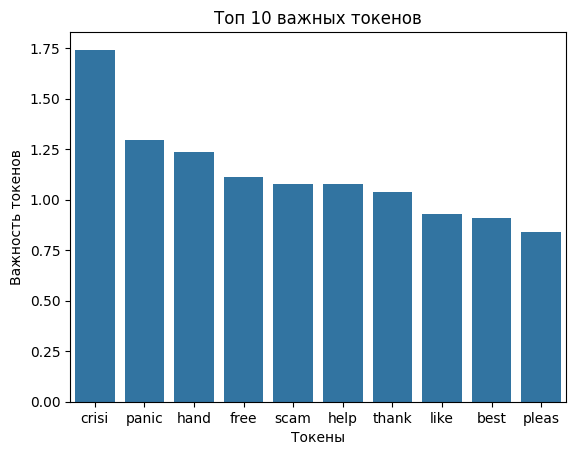

In [62]:
coefs = list(map(abs, model4.coef_))[0]
indexes = np.argsort(coefs)[::-1][:10]
features = cv_df.get_feature_names_out()[indexes]
values = coefs[indexes]
sns.barplot(x=features, y=values)
plt.xlabel('Токены')
plt.ylabel('Важность токенов')
plt.title('Топ 10 важных токенов');


**Ответ:** По данным токенам можно сразу же охарактериховать твит. Из графика видно, что самым важным токенам по мнению модели является crisi, который говорит о негативном твите, то есть если в твите встретилось это слово, то с большей вероятностью модель отнесет его к негативному твиту. Также на столбчатой диаграммы отражены и положительные токены: free, best, like. Если они встретились в твите, то модель с большей вероятностью отнесет его к положительному твиту

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

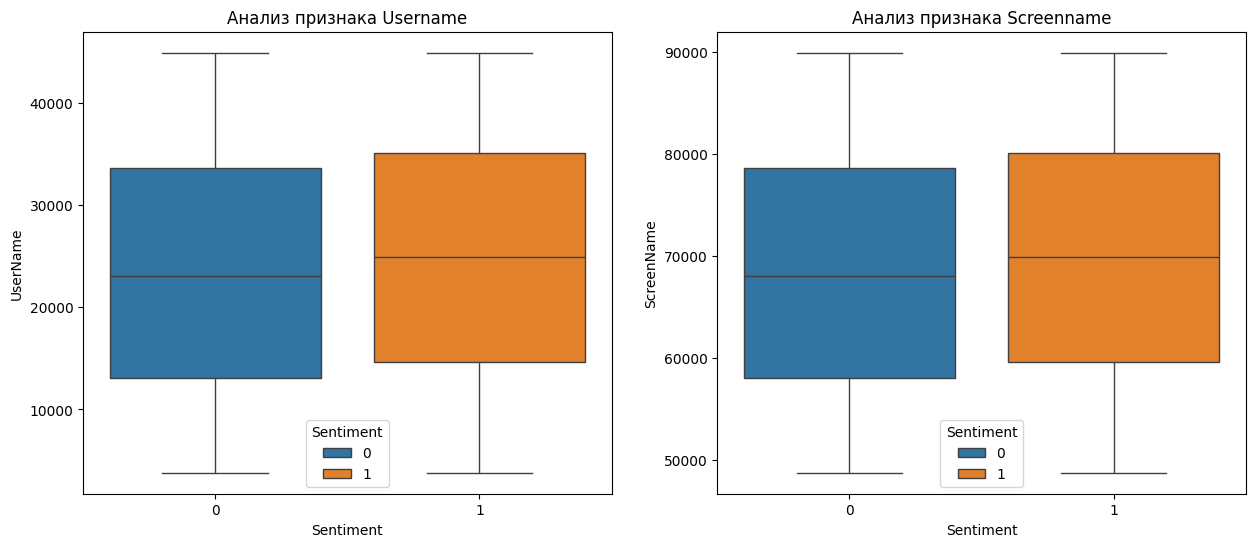

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(data=train, x='Sentiment', y='UserName', hue='Sentiment', ax=ax1)
sns.boxplot(data=train, x='Sentiment', y='ScreenName', hue='Sentiment', ax=ax2)
ax1.set_title('Анализ признака Username')
ax2.set_title('Анализ признака Screenname');

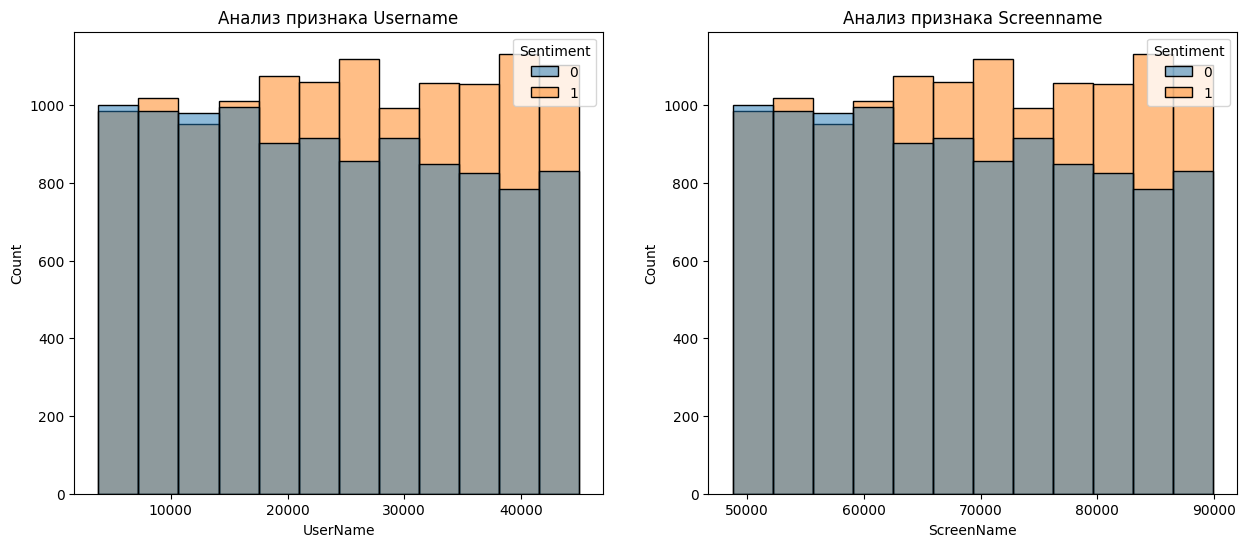

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(data=train, x='UserName', hue='Sentiment', bins=12, ax=ax1)
sns.histplot(data=train, x='ScreenName', hue='Sentiment',bins=12, ax=ax2)
ax1.set_title('Анализ признака Username')
ax2.set_title('Анализ признака Screenname');

**Ответ:** По построенным графикам видно, что они никак не влияют на целевую переменную. Ну это и логично, это просто идентификаторы устройств. Они никак не могут влиять на окраску твита

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

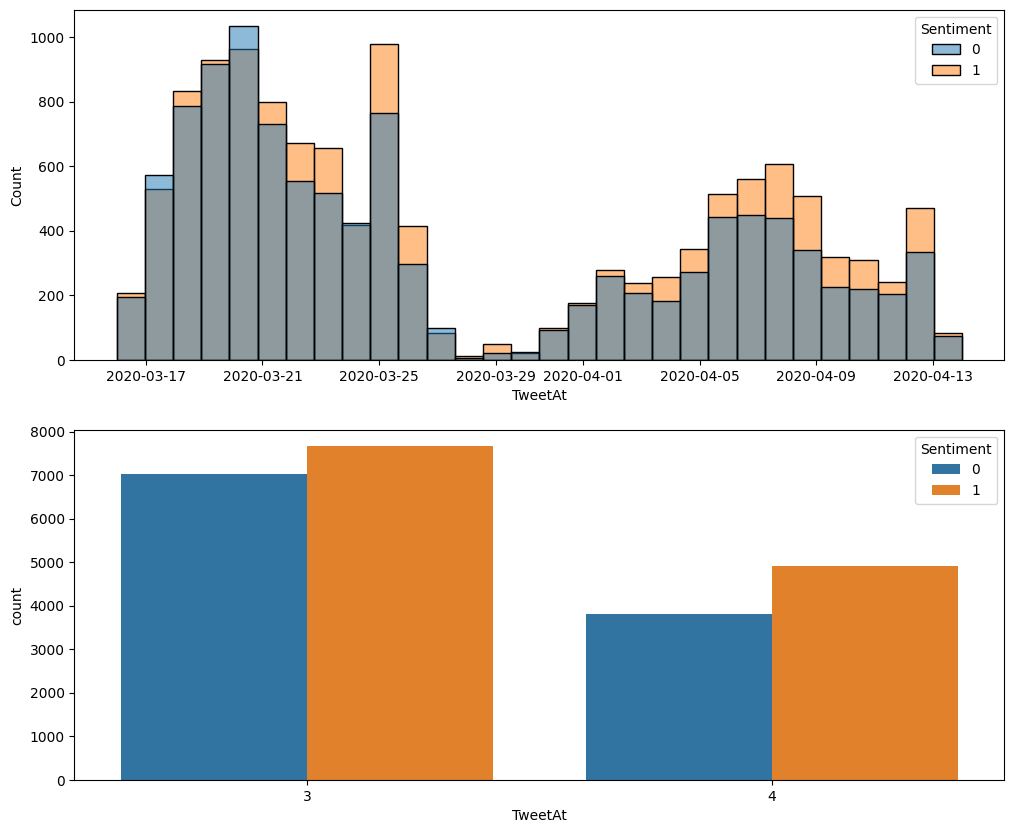

In [65]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='%d-%m-%Y')
test['TweetAt'] = pd.to_datetime(test['TweetAt'], format='%d-%m-%Y')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
sns.histplot(data=train, x='TweetAt', hue='Sentiment', bins=30, ax=ax1)
sns.countplot(data=train, x=train['TweetAt'].dt.month, hue='Sentiment', ax=ax2);

**Ответ:** # По гистограмме можно увидеть, что основное количество твитов приходится на середину каждого месяца. Также можно заметить, что сначала преоладали негативные твиты. Начиная с середины марта тенденция меняется и в большинстве случаев преобладают положительные твиты. Так что закономерность хоть и неоднозначная, но есть. Можно попробовать добавить этот признак в качестве обучения модели.



In [ ]:
scaler = StandardScaler()
X_train3 = pd.concat([pd.DataFrame(X_train1.toarray()), pd.DataFrame(train['TweetAt'].apply(lambda x: x.date().weekday()+1)).reset_index(drop=True).rename(columns={'TweetAt': 36650})], axis=1)
X_test3 = pd.concat([pd.DataFrame(X_test1.toarray()), pd.DataFrame(test['TweetAt'].apply(lambda x: x.date().weekday()+1)).reset_index(drop=True).rename(columns={'TweetAt': 36650})], axis=1)
X_train3_scaler = scaler.fit_transform(X_train3)
X_test3_scaler = scaler.transform(X_test3)

In [ ]:
model5 = LogisticRegression(max_iter=2000, n_jobs=-1)
model5.fit(X_train3_scaler, y_train)
print(f'Accuracy на тренировочной выборке: {accuracy_score(y_train, model5.predict(X_train3_scaler))}')
print(f'Accuracy на тестовой выборке:{accuracy_score(y_test, model5.predict(X_test3_scaler))}')

Accuracy на тренировочной выборке: 0.9999572832123025
Accuracy на тестовой выборке:0.7825393661550728


Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [66]:
train['Location'].value_counts()

Location
Unknown                           4944
London                             301
United States                      295
London, England                    274
New York, NY                       223
                                  ... 
Work: Kent and Live: Sussex          1
Somewhere on TradingView             1
Honolulu, Hawai?i                    1
SFO                                  1
Waterville, Ireland Austin, TX       1
Name: count, Length: 7949, dtype: int64

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

<Axes: xlabel='Location'>

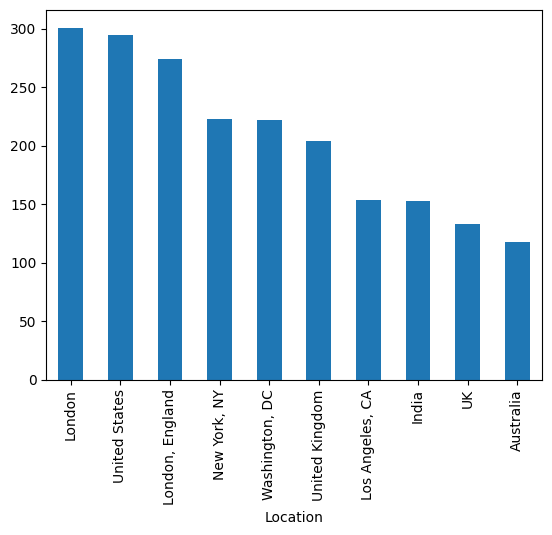

In [67]:
withot_unknown_top_10 = train['Location'].value_counts()[1:11]
withot_unknown_top_10.plot(kind='bar')

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

<Axes: xlabel='WiderLocation'>

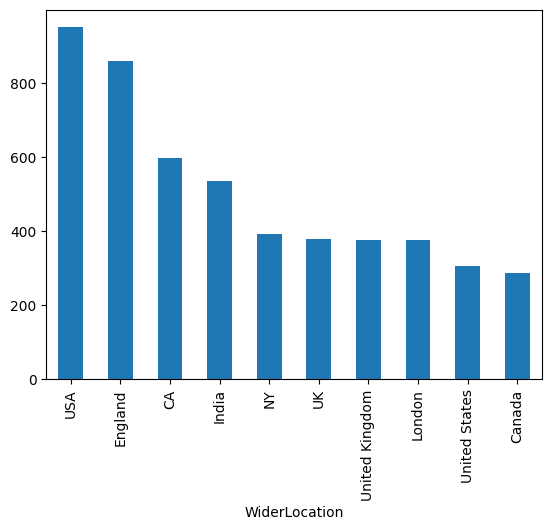

In [68]:
train['WiderLocation'] = train['Location'].str.split(', ')
train['WiderLocation'] = train['WiderLocation'].apply(lambda x: x[-1])
withot_unknown_top_10 = train['WiderLocation'].value_counts()[1:11]
withot_unknown_top_10.plot(kind='bar')

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [69]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
counts_unique_counties = train['WiderLocation'].value_counts()
new_train_df = train[train['WiderLocation'].isin(counts_unique_counties[counts_unique_counties > 1].index)].reset_index(drop=True)
new_train_df['WiderLocation'].nunique()

1010

In [70]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(new_train_df[['WiderLocation']])
codes = encoder.transform(new_train_df[['WiderLocation']])
one_hot_df = pd.DataFrame(codes, columns=encoder.get_feature_names_out(['WiderLocation']))
new_train_df = pd.concat([new_train_df, one_hot_df], axis=1)
new_train_df['TweetAt'] = new_train_df['TweetAt'].apply(lambda x: x.date().weekday()+1)


In [71]:
test['WiderLocation'] = test['Location'].str.split(', ')
test['WiderLocation'] = test['WiderLocation'].apply(lambda x: x[-1])
new_test_df = test[test['WiderLocation'].isin(counts_unique_counties[counts_unique_counties > 1].index)].reset_index(drop=True)
codes = encoder.transform(new_test_df[['WiderLocation']])
one_hot_df = pd.DataFrame(codes, columns=encoder.get_feature_names_out(['WiderLocation']))
new_test_df = pd.concat([new_test_df, one_hot_df], axis=1)
new_test_df['TweetAt'] = new_test_df['TweetAt'].apply(lambda x: x.date().weekday()+1)


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [72]:
cv.fit(new_train_df['OriginalTweet'])
X_train = cv.transform(new_train_df['OriginalTweet']).toarray()
X_test = cv.transform(new_test_df['OriginalTweet']).toarray()
new_train_df = pd.concat([new_train_df, pd.DataFrame(X_train)], axis=1)
new_test_df = pd.concat([new_test_df, pd.DataFrame(X_test)], axis=1)
tmp = new_train_df['Sentiment']
new_train_df.drop(columns=['Sentiment', 'WiderLocation', 'Location', 'UserName', 'ScreenName', 'OriginalTweet'], inplace=True)
new_train_df['Sentiment'] = tmp
tmp = new_test_df['Sentiment']
new_test_df.drop(columns=['Sentiment', 'WiderLocation', 'Location', 'UserName', 'ScreenName', 'OriginalTweet'], inplace=True)
new_test_df['Sentiment'] = tmp

new_train_df.columns = new_train_df.columns.astype(str)
new_test_df.columns = new_test_df.columns.astype(str)


In [73]:
model = LogisticRegression(max_iter=2000)
model.fit(new_train_df.iloc[:, :-1], new_train_df['Sentiment'])
print(f"Accuracy на тренировочной выборке: {accuracy_score(new_train_df['Sentiment'], model.predict(new_train_df.iloc[:, :-1]))}")
print(f"Accuracy на тестовой выборке:{accuracy_score(new_test_df['Sentiment'], model.predict(new_test_df.iloc[:, :-1]))}")

Accuracy на тренировочной выборке: 0.9774347402430894
Accuracy на тестовой выборке:0.8623956126137355


**Ответ:** качество осталось примерно таким же, признак не особо полезен

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [157]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=0)

In [158]:
import pycountry
countries = {country.name.upper(): country.alpha_2 for country in pycountry.countries}
countries.update({country.alpha_2: country.alpha_2 for country in pycountry.countries})

def get_wider_location(location):
    parts = [part.strip().upper() for part in location.split(',')]
    
    for part in parts:
        if part in countries:
            return countries[part]
    return parts[-1]
train_df['WiderLocation'] = train_df['Location'].apply(get_wider_location)
test_df['WiderLocation'] = test_df['Location'].apply(get_wider_location)

In [159]:
counts_unique_counties = train_df['WiderLocation'].value_counts()
train_df = train_df[train_df['WiderLocation'].isin(counts_unique_counties[counts_unique_counties > 1].index)].reset_index(drop=True)

In [160]:
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(train_df[['WiderLocation']])
codes = encoder.transform(train_df[['WiderLocation']])
one_hot_df = pd.DataFrame(codes, columns=encoder.get_feature_names_out(['WiderLocation']))
train_df = pd.concat([train_df, one_hot_df], axis=1)



test_df = test_df[test_df['WiderLocation'].isin(counts_unique_counties[counts_unique_counties > 1].index)].reset_index(drop=True)
codes = encoder.transform(test_df[['WiderLocation']])
one_hot_df = pd.DataFrame(codes, columns=encoder.get_feature_names_out(['WiderLocation']))
test_df = pd.concat([test_df, one_hot_df], axis=1)

In [161]:
cv.fit(train_df['OriginalTweet'])
X_train = cv.transform(train_df['OriginalTweet']).toarray()
X_test = cv.transform(test_df['OriginalTweet']).toarray()

train_df = pd.concat([train_df, pd.DataFrame(X_train)], axis=1)
test_df = pd.concat([test_df, pd.DataFrame(X_test)], axis=1)





In [ ]:
tmp = train_df['Sentiment']
train_df.drop(columns=['Sentiment', 'WiderLocation', 'Location', 'UserName', 'ScreenName', 'OriginalTweet'], inplace=True)
train_df['Sentiment'] = tmp
tmp = test_df['Sentiment']
test_df.drop(columns=['Sentiment', 'WiderLocation', 'Location', 'UserName', 'ScreenName', 'OriginalTweet'], inplace=True)
test_df['Sentiment'] = tmp


train_df['TweetAt'] = pd.to_datetime(train_df['TweetAt'], format='%d-%m-%Y')
test_df['TweetAt'] = pd.to_datetime(test_df['TweetAt'], format='%d-%m-%Y')
train_df['TweetAt'] = train_df['TweetAt'].apply(lambda x: x.date().weekday()+1)
test_df['TweetAt'] = test_df['TweetAt'].apply(lambda x: x.date().weekday()+1)


train_df.columns = train_df.columns.astype(str)
test_df.columns = test_df.columns.astype(str)

In [163]:
train_df.shape, test_df.shape

((20009, 33927), (8264, 33927))

In [137]:
model = LogisticRegression(max_iter=2000)
model.fit(train_df.iloc[:, :-1], train_df['Sentiment'])
print(f"Accuracy на тренировочной выборке: {accuracy_score(train_df['Sentiment'], model.predict(train_df.iloc[:, :-1]))}")
print(f"Accuracy на тестовой выборке:{accuracy_score(test_df['Sentiment'], model.predict(test_df.iloc[:, :-1]))}")

Accuracy на тренировочной выборке: 0.9765105702433905
Accuracy на тестовой выборке:0.8633833494675702


In [138]:
from sklearn.linear_model import RidgeClassifierCV
model_rb = RidgeClassifierCV()
model_rb.fit(train_df.iloc[:, :-1], train_df['Sentiment'])
print(f"Accuracy на тренировочной выборке: {accuracy_score(train_df['Sentiment'], model_rb.predict(train_df.iloc[:, :-1]))}")
print(f"Accuracy на тестовой выборке:{accuracy_score(test_df['Sentiment'], model_rb.predict(test_df.iloc[:, :-1]))}")

Accuracy на тренировочной выборке: 0.9670148433205058
Accuracy на тестовой выборке:0.8532187802516941


In [ ]:
from lightgbm import LGBMClassifier
model_lgb = LGBMClassifier()
model_lgb.fit(train_df.iloc[:, :-1].to_numpy(), train_df['Sentiment'].to_numpy())
print(f"Accuracy на тренировочной выборке: {accuracy_score(train_df['Sentiment'].to_numpy(), model_lgb.predict(train_df.iloc[:, :-1].to_numpy()))}")
print(f"Accuracy на тестовой выборке:{accuracy_score(test_df['Sentiment'].to_numpy(), model_lgb.predict(test_df.iloc[:, :-1].to_numpy()))}")

[LightGBM] [Info] Number of positive: 10796, number of negative: 9213
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6683
[LightGBM] [Info] Number of data points in the train set: 20009, number of used features: 2358
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539557 -> initscore=0.158560
[LightGBM] [Info] Start training from score 0.158560
Accuracy на тренировочной выборке: 0.8790044479984007
Accuracy на тестовой выборке:0.8468054211035818
